In [16]:
# Perform Data Wrangling (cleaning, feature extraction and analysis) on raw datasets
# Data set was retrieved from an artificial pancreas
# Data set contains 40,000 rows and 55,000 rows
# Perform machine learning on processed data
# Train a model to predict whether a person has had a meal or not

In [17]:
import pandas as pd
from datetime import timedelta
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

In [18]:
# InsulinData.csv contains the time when a person eats a meal, indicated by a manual entry record of Carb value
# CGMData.csv contains records of insulin level (mg/dL) in the body every 5 min of the day

# The goal is to retrieve two types of data from CGMData.csv:

# A MEAL data comprises of 2hr stretch of time that starts from recorded time of meal and extends to tm+2hr
# A NO-MEAL data comprises of 2hr stretch of time that is not part of meal data. 

In [19]:
def get_time():
    
    # read csv files
    df = pd.read_csv('InsulinData.csv', low_memory=False)
    df2 = pd.read_csv('CGMData.csv', low_memory=False)
    
    # retrieve rows with carb value greater than 0 and less than 1000
    grams = df.loc[(df['BWZ Carb Input (grams)'] <= 1000) 
                  & (df['BWZ Carb Input (grams)'] > 0)]
    
    # print(grams['BWZ Carb Input (grams)'])

    # length of data
    i = len(grams) - 1
    
    # retrieve the times of meal data
    outtime = []
    
    # start from the bottom of the file, iterate through every row
    while i > 0:
        date_time0 = pd.to_datetime(grams.iloc[i - 1, 1] + ' ' + grams.iloc[i - 1, 2])
        date_time1 = pd.to_datetime(grams.iloc[i - 2, 1] + ' ' + grams.iloc[i - 2, 2])

        # there is no meal within 2 hours stretch of time
        if (date_time1 >= (date_time0 + timedelta(days=0, hours=2))):
            outtime.append(str(date_time0))
        i = i - 1
    
    # get Sensor Glucose (mg/dL) values from CGM files
    # convert times to pd times
    cgm_meal_times = pd.to_datetime(df2['Date'] + ' ' + df2['Time'])
    insulin_meal_times = pd.to_datetime(outtime)
    
    get_values(cgm_meal_times, insulin_meal_times, df2)

In [20]:
def get_values(cgm_meal_times, insulin_meal_times, df2):
    
    column = ['1','2','3','4','5','6','7',
              '8','9','10','11','12','13',
              '14','15','16','17','18','19',
              '20','21','22','23','24']
    meal_df = pd.DataFrame(columns=column)
    nomeal_df = pd.DataFrame(columns=column)
    
    x, y = 0, 0
    while x < len(insulin_meal_times):
        # GET MEAL DATA
        # get rows from cgm data within 2.5 hours stretch of time
        meal_row = df2.loc[(cgm_meal_times >= (insulin_meal_times[x])) &
                (cgm_meal_times <= (insulin_meal_times[x]) + timedelta(hours=2))]
        
        # get sensor glucose values only
        meal_value = meal_row['Sensor Glucose (mg/dL)'].tolist()
        
        # clean data, only 2.5 hours stretch of time that has 30 values
        if (len(meal_value) == 24): 
            meal_df.loc[x] = meal_value
        
        
        # GET NO MEAL DATA
        # get rows from cgm data [ insulin time + 2 hours <= cgm no meal times <= next insulin time ]
        if (x < (len(insulin_meal_times) - 1)):
            nomeal_row = df2.loc[(cgm_meal_times >= (insulin_meal_times[x] + timedelta(hours=2))) &
                (cgm_meal_times <= (insulin_meal_times[x + 1]))]
        
        # get sensor glucose values only
        nomeal_value = nomeal_row['Sensor Glucose (mg/dL)'].tolist()
        
        # breakup no meal rows to pieces of 24 
        a, b = 0, 24
        length_nomeal = len(nomeal_value)
        while length_nomeal/24 >= 1:
            # append 24 values to dataframe
            nomeal_df.loc[y] = nomeal_value[a:b]
            # print(nomeal_df)
            a = a + 24
            b = b + 24
        
            length_nomeal = length_nomeal - 24
            y = y + 1   
            
        x = x + 1
            
    # clean data, drop rows with nan
    
    meal_df = meal_df.dropna().reset_index().drop('index', 1)
    nomeal_df = nomeal_df.dropna().reset_index().drop('index', 1)
    
    # reverse order of meal dataframe so the first meal is at index 0
    meal_df = meal_df.iloc[:, ::-1]

    # visualize data
    visualize(meal_df, nomeal_df)
    
    # get features
    feature_extraction(meal_df, nomeal_df)

In [21]:
# extract features from cleaned data to efficiently train machine models
def prepare_data(data, string):
    
    # Take the difference in GLUCOSE between the highest maxValue and start of meal
    # Take the difference in TIME between the highest maxValue and start of meal
    
    # dataframe for feature extraction
    column = ['maxval', 'firstval', 'indexof_max', 'indexof_first', 'class']
    df = pd.DataFrame(columns=column)
 
    # Get max values of each row for both meal and nomeal data
    df['maxval'] = data.max(axis=1)

    # Get first value 
    df['firstval'] = data.iloc[:, 0]
    
    # get time difference, multiply by 5 minutes
    df['indexof_max'] = (data.idxmax(axis=1).astype('int64') - 24).abs() * 5
    df['indexof_first'] = 0
    
    # assign class
    if string=='meal_df' : 
         # meal time difference
        df['class'] = 1
        return df
    
    else: 
        # nomeal time difference
        df['class'] = 0
        return df

In [22]:
def feature_extraction(meal_df, nomeal_df):
    
    maxvalues_meal = prepare_data(meal_df, 'meal_df')
    maxvalues_nomeal = prepare_data(nomeal_df, 'nomeal_df')
    
    # print(maxvalues_meal)
    
    # append two data
    maxvalues_meal = maxvalues_meal.append(maxvalues_nomeal, ignore_index=True)

    features = pd.DataFrame(columns=['feature1', 'feature2', 'class'])
    features['feature1'] = (((maxvalues_meal['maxval'] - maxvalues_meal['firstval']) / maxvalues_meal['firstval']) + 1).round(3)
    features['feature2'] = (maxvalues_meal['indexof_max'] - maxvalues_meal['indexof_first']).astype('int64') + 1
    features['class'] = maxvalues_meal['class']

    # train data
    x_data = features[['feature1', 'feature2']]
    y_data = features['class']
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True)
    
    # test data
    train_test(x_train, x_test, y_train, y_test)

In [23]:
# visualize meal_df and nomeal_df

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import numpy as np

def visualize(meal_df, nomeal_df):
    
    # average meal and no meal data based on time
    x = meal_df.mean().tolist()
    y = nomeal_df.mean().tolist()
    
    # get time - idx * 5 minutes
    z = []
    for val in x: z.append(x.index(val)*5)
    
    # line chart
    
    # meal average from start of meal to end
    plt.plot(z, x, label='meal average')
    # no meal average over time
    plt.plot(z, y, label='no meal average')
    # labels
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('Insulin Level Average (mg/dL)', fontsize=12)
    # legend
    plt.legend(loc="upper right", prop={'size': 8})

In [24]:
def train_test(x_train, x_test, y_train, y_test):
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    print("Decision Tree")
    print(classification_report(y_test, predictions))
    
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(x_train, y_train)
    predictions1 = neigh.predict(x_test)
    print("K Neighbors")
    print(classification_report(y_test, predictions1))
    # print(cross_val_score(neigh, x_train, y_train, cv=10))
    
    logis = LogisticRegression()
    logis.fit(x_train, y_train)
    predictions2 = logis.predict(x_test)
    print("Logistic Regression")
    print(classification_report(y_test, predictions2))
    
    random = RandomForestClassifier(random_state=0)
    random.fit(x_train, y_train)
    predictions3 = random.predict(x_test)
    print("Random Forest Classifier")
    print(classification_report(y_test, predictions3))
    
    gradient = GradientBoostingClassifier(random_state=0)
    gradient.fit(x_train, y_train)
    predictions4 = gradient.predict(x_test)
    print("Gradient Boosting Classifier")
    print(classification_report(y_test, predictions4))

Decision Tree
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       238
           1       0.68      0.75      0.72        92

    accuracy                           0.83       330
   macro avg       0.79      0.81      0.80       330
weighted avg       0.84      0.83      0.84       330

K Neighbors
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       238
           1       0.69      0.76      0.73        92

    accuracy                           0.84       330
   macro avg       0.80      0.82      0.81       330
weighted avg       0.85      0.84      0.84       330

Logistic Regression
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       238
           1       0.60      0.03      0.06        92

    accuracy                           0.72       330
   macro avg       0.66      0.51      0.45       330
weighted avg       0.69     

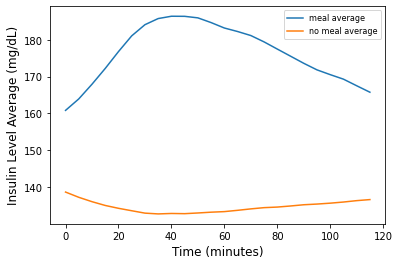

In [26]:
get_time()